# Projet Data Camp

This project can be found at "./datacamp.pdf". The aim is to find a way to maximize the "cells" size eaten at specific location within a limited range of time.

## Preprocessing

In this section, we will import, open data and manage to explore and maybe reorganize them.

### Imports

In [32]:
# Datascience libraries
import pandas as pd
import numpy as np
import keras
from keras.layers import Dense
from keras.models import Sequential, load_model

# basic python libraries
import math
import time
from tqdm.notebook import tqdm as pb

# plot
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 16, 10

# local imports
from classes.Game import *
from classes.Strategy import *
from classes.Metrics import *

In [33]:
#Parser de fichiers
df = pd.read_csv("data.txt",header=None)
df.head()

,0,1,2,3
0,0,-11.03,-82.33,46
1,1,-4.93,-98.05,96
2,2,81.52,2.41,49
3,3,36.82,-42.62,71
4,4,-69.86,11.88,27


In [34]:
df.iloc[8,:]

0     8.00
1   -56.27
2    23.81
3    65.00
Name: 8, dtype: float64

## Reduce Graph and store it

In [35]:
import json
def ReduceGraph(df, neightbors):
    def find_n_nearest_neightbors(M, position, range_, range2_):
        temp = [([M[j,0], math.sqrt((M[position,1] - M[j,1])**2 + (M[position,2] - M[j,2])**2)]) for j in range2_]
        # select the n best
        temp.sort(key=lambda x: x[1])
        return [temp[j] for j in range_]

    temp = []
    M = df.values
    range_ = range(1,neightbors+1)
    range2_ = range(M.shape[0])
    with open('{}neightbors_matrix.json'.format(neightbors), 'w') as outfile:
        json.dump([(find_n_nearest_neightbors(M, i, range_, range2_)) for i in pb(range2_)], outfile)
        
def LoadGraph(neightbors):
    with open('{}neightbors_matrix.json'.format(neightbors)) as json_file:
        return np.array(json.load(json_file))

In [36]:
#ReduceGraph(df, 2000)

In [37]:
_n_neightbors = 30
new_df = LoadGraph(30)
new_df.shape

(10000, 30, 2)

## deep rl

In [70]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        super(ReplayBuffer, self).__init__()
        self.mem_size = max_size
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.mem_counter = 0
        
    def store_transition(self, state, action, reward, new_state, done):
        index = self.mem_counter % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = new_state
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - int(done)
        
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.mem_counter += 1
        
    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_counter, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)
        
        states = self.state_memory[batch]
        new_states = self.new_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        terminal = self.terminal_memory[batch]
        
        return states, actions, rewards, new_states, terminal

In [71]:
class Agent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size, input_dims,
                fn, epsilon_decrease=0.0001, epsilon_min=0.0001, mem_size=1000000,
                fname="dqn_model"):
        super(Agent, self).__init__()
        self.action_space = [i for i in range(n_actions)]
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.model_file = fname
        
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions, 
                                   discrete=True)
        self.q_eval = fn(alpha, n_actions, input_dims, 128, 128)
    
    def remember(self, state, action, reward, new_state, done):
        states_previous = np.array([-(state[i][1]**3/state[i][2]) if state[i][2] != 0. else -1000. for i in range(len(state))])
        states_next = np.array([-(new_state[i][1]**3/new_state[i][2]) if new_state[i][2] != 0. else -1000. for i in range(len(state))])
        self.memory.store_transition(states_previous, action, reward, states_next, done)
        
    def choose_action(self, state, time):
        distances = np.array([state[i][1] for i in range(len(state))])
        state_ = np.array([-(state[i][1]**3/state[i][2]) if state[i][2] != 0. else -1000. for i in range(len(state))])
        state_ = state_[np.newaxis,:]
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            actions = self.q_eval.predict(state_)
            action = np.argmax(actions)
            
        if time - distances[action] < 0:
            return (-1,-1)
        else:
            return (state[action][0], action)
    
    def learn(self):
        if self.memory.mem_counter < self.batch_size:
            return
        state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)
        
        action_values = np.array(self.action_space, dtype=np.int8)
        action_indices = np.dot(action, action_values)
        
        q_eval = self.q_eval.predict(state)
        q_next = self.q_eval.predict(new_state)
        
        q_target = q_eval.copy()
        
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        q_target[batch_index, action_indices] = reward + self.gamma*np.max(q_next, axis=1)*done
        
        
        _ = self.q_eval.fit(state, q_target, verbose=0)
        
        
    def decrease(self):
        self.epsilon = self.epsilon-self.epsilon_dec if self.epsilon > self.epsilon_min else self.epsilon_min
    def save_model(self):
        self.q_eval.save(self.model_file)
    def load_model(self):
        self.q_eval = load_model(self.model_file)

In [72]:
class Game(object):
    
    def __init__(self, time, n):
        super(Game, self).__init__()
        self._const_time = time
        self.n = n
    
    # init a game and reset it
    def init_game(self, M, init_coord):
        self._Values = M[:,1:]
        self._Ids = M[:, 0].astype(int)
        self.actual_coord = (init_coord[0], init_coord[1],-1)
        self.ids = []
        self.rewards = []
        self.time = 0.
        return self.find_n_nearest_neightbors(self.actual_coord)
    
    
    def find_n_nearest_neightbors(self, position):
        temp = []
        for j in range(self._Values.shape[0]):
            pos = (self._Ids[j], self._Values[j,0], self._Values[j,1], self._Values[j,2])
            temp.append([pos[0], math.sqrt((position[0] - pos[1])**2 + (position[1] - pos[2])**2), pos[3]])
        # select the n best
        temp.sort(key=lambda x: x[1])
        return [temp[j] for j in range(self.n)]

    # step in a game
    def step_env(self, action):
        # check if there is a correct action or not
        if action[1] == -1:
            temp = np.zeros((self.n,3))
            for i in range(temp.shape[0]):
                temp[i,1]=0
            return temp, 1, True, "End of Game"
        else:
            # get reward
            distance = math.sqrt((self.actual_coord[0] - self._Values[action[0], 0])**2 + (self.actual_coord[1] - self._Values[action[0], 1])**2)
            if self._Values[action[0], 2] == 0.:
                previous_reward = -10000
            else:
                previous_reward = - (distance**3/self._Values[action[0], 2])
            self.rewards.append(self._Values[action[0], 2])
            self._Values[action[0], 2] = 0.

            # keep track of action
            self.ids.append(self._Ids[action[0]])
            

            # update time and coordinate
            self.time += distance
            self.actual_coord = (self._Values[action[0], 0], self._Values[action[0], 1], self._Ids[action[0]])

            # step into the environnement
            if self.time < self._const_time:
                possibilities = self.find_n_nearest_neightbors(self.actual_coord)
                return possibilities, previous_reward, False, "Step"
            else:
                temp = np.zeros((self.n,3))
                for i in range(temp.shape[0]):
                    temp[i,1]=0
                # previous time was not correctly endled by the agent(strategy)
                return temp, -10000, True, "Time is out of bound"
    
        
    
    # string representation of the object
    def __repr__(self):
        return "<Object : Game (DataCamp) <> time:{}>".format(self._const_time)
    def __str__(self):
        return self.__repr__()

In [73]:
def build_network(learning_rate, n_actions, input_dims, fc1_dims, fc2_dims):
    model = Sequential()
    model.add(Dense(fc1_dims, input_shape=(input_dims,), activation='relu'))
    model.add(Dense(fc2_dims, activation='relu'))
    model.add(Dense(n_actions, activation='softmax'))
    
    model.compile(optimizer="adam",loss="mse")
    
    return model

In [76]:
M = df.values
n = 100
env = Game(10000., n)
agent = Agent(gamma=0.90, epsilon=1.0, alpha=0.001, input_dims=n, n_actions=n,
             fn=build_network,mem_size=10_000, batch_size=16)
#agent.load_model()

In [77]:
_n_games = 100
scores = []
max_ = [0]
for epoch in range(1):
    agent.epsilon = 1.
    agent.epsilon_decrease= 1./_n_games,
    agent.epsilon_min= 1./_n_games
    for i in pb(range(_n_games)):
        done = False
        observation = env.init_game(np.copy(M), (0,0))
        while not done:
            action = agent.choose_action(observation, env._const_time - env.time)
            observation_, reward, done, info = env.step_env(action)
            agent.remember(observation, action[1], reward, observation_, done)
            observation = observation_
            agent.learn()
        agent.decrease()
        if max_[0] < sum(env.rewards):
            max_ = [sum(env.rewards), env.ids]
        scores.append(sum(env.rewards))
    agent.save_model() 

KeyboardInterrupt: 

In [78]:
agent.save_model() 

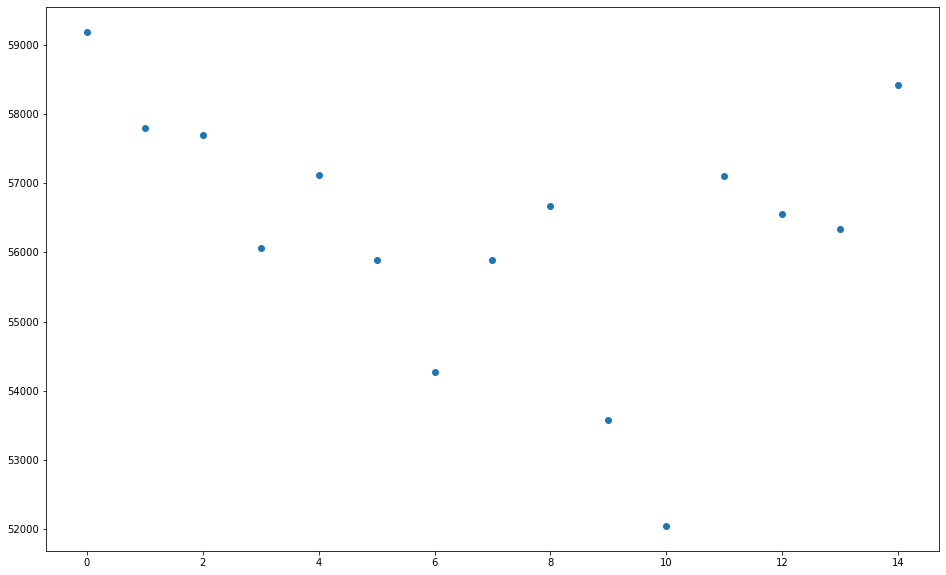

In [79]:
plt.scatter(np.arange(0, len(scores)),scores)

In [46]:
agent = Agent(gamma=0.90, epsilon=0., alpha=0.001, input_dims=_n_neightbors, n_actions=_n_neightbors,
             fn=build_network,mem_size=100_000, batch_size=750)
agent.epsilon_decrease= 0.
agent.epsilon_min= 0.
agent.load_model()

In [47]:
done = False
observation = env.init_game(np.copy(M), (0,0))
while not done:
    action = agent.choose_action(observation, env._const_time - env.time)
    observation_, reward, done, info = env.step_env(action)
    agent.remember(observation, action[1], reward, observation_, done)
    observation = observation_
print(sum(env.rewards), len(env.ids))

188.0 15414


In [48]:
print(len(max_[1]), max_[0])

2455 65925.0


In [49]:
def check_result(M, ids):
    M_temp = np.copy(M)
    rewards = []
    dist = 10000.
    coordinate = (0.,0.)
    for i in ids:
        rewards.append(M_temp[i, 3])
        M_temp[i, 3] = 0.
        dist -= math.sqrt((coordinate[0] - M_temp[i, 1])**2 + (coordinate[1] - M_temp[i, 2])**2)
        coordinate = (M_temp[i, 1],M_temp[i, 2])
        
    print(dist, sum(rewards))

In [50]:
check_result(M,max_[1])

2.5349012459854574 65925.0
